<a id="top"></a>
# Water Quality - Total Suspended Matter

<hr>

# Notebook Summary

This notebook shows results for three empirical algorithms and one spectral index 
addressing total suspended sediment (TSM), or total suspended matter (TSM). 
It should be noted that these algorithms were developed for specific regions of the world 
and are not valid universally. In addition, the Landsat 8 data is standard 
surface reflectance and not water leaving radiance, so the accuracy of the results 
are likely worse since water radiance is very low and small differences in 
atmospheric corrections can vastly change the results. Finally, the colorbar (legend) 
for these results have been removed to avoid showing specific quantities 
for the TSM results. It is best to use these results to assess coarse spatial 
and temporal differences (e.g. low, medium, high). With improvements in 
analysis-ready data (e.g. water leaving radiance) and with in-situ sampling of 
water bodies for empirical modeling, it will be possible to increase the accuracy 
of these water quality results and even consider the numerical output.

It should also be noted that this notebook is best used with the 
[DCAL Cloud Statistics notebook](DCAL_Cloud_Statistics.ipynb) in order to identify clear scenes with no cloud contamination. 

For more information about WOfS, visit [this website](http://www.ga.gov.au/scientific-topics/hazards/flood/wofs).

<hr>

# Index  

* Import Dependencies and Connect to the Data Cube
* Choose Platform and Product
* Get the Extents of the Cube
* Define the Analysis Parameters
* Load Data from the Data Cube
* Obtain a Median Composite and Show the Water Extent for That Composite
* Total Suspended Sediment Algorithms
    * Lymburner TSM (Total Suspended Matter) Algorithm
    * Suspended Particulate Model (SPM)
    * NDSSI - Normalized Difference Suspended Sediment Index
    * Quang Total Suspended Solids (TSS) Algorithm
    * Grid Plot of TSM Algorithm Outputs for the Composite

## Import Dependencies and Connect to the Data Cube

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr  

import datacube
import utils.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## Choose Platform and Product

In [2]:
# Get available products
products_info = dc.list_products()
products_info

,name,description,lat,instrument,product_type,format,platform,time,label,creation_time,lon,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,None,ETM,LEDAPS,GeoTiff,LANDSAT_7,None,None,None,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Level2 Surface Ref...,None,OLI_TIRS,LaSRC,GeoTiff,LANDSAT_8,None,None,None,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"


In [3]:
# List LANDSAT 7 products (remove comments below to see list of products)
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [4]:
# List LANDSAT 8 products (remove comments below to see list of products)
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select a Product and Platform (choose only one platform/product combination)
# The water quality community typically uses Landsat 8 vs. Landsat 7 due to its increased SNR

# product = "ls7_usgs_sr_scene"
# platform = "LANDSAT_7"

product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8"

## Get the Extents of the Cube

In [6]:
from utils.dc_load import get_product_extents
from utils.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.63361111121218, 18.40166666681388)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-27']


In [7]:
from utils.dc_display_map import display_map

# Display the total area available for the selected datacube product(s).
display_map(latitude = full_lat,longitude = full_lon)

## Define the Analysis Parameters

In [8]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Northern Lake Manyara, Tanzania
# Clear dates: 1/25/14, 2/13/15, 2/16/16, 1/17/17, 12/3/17
latitude =  (-3.8011, -3.3885) 
longitude =  (35.6823, 35.9386)

# Weija Reservoir, Ghana
# Clear date: 1/12/2018
# latitude =  (5.541, 5.625) 
# longitude =  (-0.404, -0.328)

# Time Period
time_extents = ('2016-02-15', '2016-02-17')

In [9]:
# The code below renders a map that can be used to view the region.
display_map(latitude,longitude)

## Load Data from the Data Cube

In [10]:
from utils.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset = dc.load(latitude = latitude,
                  longitude = longitude,
                  platform = platform,
                  time = time_extents,
                  product = product,
                  measurements = measurements,
                  group_by='solar_day', dask_chunks={'time':1}).compute()
# Get the clean mask.
clean_mask = landsat_qa_clean_mask(dataset, platform) & \
             (dataset != -9999).to_array().all('variable') & \
             landsat_clean_mask_invalid(dataset)
# Remove the 'pixel_qa' band since we have the clean mask.
dataset = dataset.drop('pixel_qa')
# Clean the data.
dataset = dataset.astype(np.float32).where(clean_mask)

In [11]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

dataset

<xarray.Dataset>
Dimensions:    (latitude: 1486, longitude: 923, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2016-02-16T07:49:41.042103
  * longitude  (longitude) float64 35.68 35.68 35.68 35.68 ... 35.94 35.94 35.94
  * latitude   (latitude) float64 -3.388 -3.389 -3.389 ... -3.8 -3.801 -3.801
Data variables:
    red        (time, latitude, longitude) float32 639.0 604.0 600.0 ... nan nan
    green      (time, latitude, longitude) float32 514.0 513.0 499.0 ... nan nan
    blue       (time, latitude, longitude) float32 234.0 240.0 235.0 ... nan nan
    nir        (time, latitude, longitude) float32 1790.0 1906.0 ... nan nan
    swir1      (time, latitude, longitude) float32 1476.0 1452.0 ... nan nan
    swir2      (time, latitude, longitude) float32 1072.0 1064.0 ... nan nan
Attributes:
    crs:      EPSG:4326

## Obtain a Median Composite and Show the Water Extent for That Composite

In [12]:
from utils.dc_mosaic import create_median_mosaic

# Create a median mosaic for viewing only
dataset_composite = create_median_mosaic(dataset, clean_mask)

In [13]:
from utils.dc_water_classifier import wofs_classify

dataset_composite['water'] = wofs_classify(dataset_composite, mosaic = True).wofs

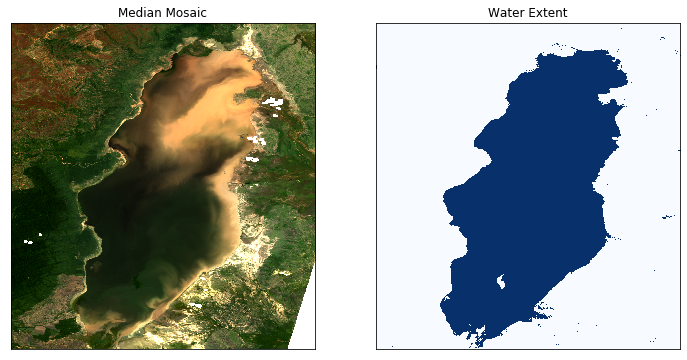

In [14]:
from utils.dc_rgb import rgb

fig, ax = plt.subplots(1, 2, figsize=(12,6))

composite_rgb = dataset_composite[['red', 'green', 'blue']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
rgb_vmin = composite_rgb.quantile(0.02).values
rgb_vmax = composite_rgb.quantile(0.98).values

# Plot the resulting 2 products ... Baseline RGB, Water Extent
composite_rgb.plot.imshow(ax=ax[0], vmin=rgb_vmin, vmax=rgb_vmax)
dataset_composite.water.plot.imshow(ax=ax[1], cmap='Blues', add_colorbar=False)

# Titles
ax[0].set_title('Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Water Extent'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)

plt.show()

## Total Suspended Sediment Algorithms

### (1) Lymburner TSM (Total Suspended Matter) Algorithm
Units of mg/L concentration
<br>TSM Index = T = (Green + Red) / 2
<br>TSM for L7 = 3983 * T ^ 1.6246
<br>TSM for L8 = 3957 * T ^ 1.6436

In [15]:
def LYM7(dataset):
        return (3983 * ((dataset.green + dataset.red)*0.0001/2)**1.6246)

In [16]:
def LYM8(dataset):
        return (3957 * ((dataset.green + dataset.red)*0.0001/2)**1.6436)

In [17]:
lym7 = LYM7(dataset_composite)  # L7 Lymburner TSM
lym8 = LYM8(dataset_composite)  # L8 Lymburner TSM

### (2) Suspended Particulate Model (SPM)
Zhongfeng Qiu et.al., 2017<br>
Using Landsat 8 data to estimate suspended particulate matter in the Yellow River estuary<br>
J. Geophys. Res. Oceans, 122, doi:10.1002/2016JC012412 <br>
<br>X = L8/OLI band ratio B4/B3 = Red/Green
<br>SPM = 10^ (2.26 X^3 - 5.42 X^2 + 5.58 X - 0.72) - 1.43
<br>SPM units in g/m^3, r^2 correlation 0.92

In [18]:
def SPM_QIU(dataset):
        return (10**(2.26*(dataset.red/dataset.green)**3 - 
                     5.42*(dataset.red/dataset.green)**2 +
                     5.58*(dataset.red/dataset.green) - 0.72) - 1.43)

In [19]:
spm_qiu = SPM_QIU(dataset_composite)

### (3) NDSSI - Normalized Difference Suspended Sediment Index
Hossain et.al., 2010 <br>
Development of Remote Sensing Based Index for Estimating/Mapping Suspended Sediment Concentration in River and Lake Environments
<br>NDSSI = (Blue-NIR)/(Blue+NIR)
<br>The NDSSI value ranges from -1 to +1. Values closer to +1 indicate presence of higher sediment

In [20]:
def NDSSI(dataset):
        return ((dataset.blue-dataset.nir)/(dataset.blue+dataset.nir))

In [21]:
ndssi = NDSSI(dataset_composite)

### (4) Quang Total Suspended Solids (TSS) Algorithm
2017 paper, Vietnam lake turbidity testing 
<br> TSS (Total Suspended Solids) units of mg/L
<br>Uses Band-4 (Red) for Landsat-8 in a linear model
<br>TSS = 380.32 * B4 - 1.7826


In [22]:
def QUANG8(dataset):
        return (380.32 * (dataset.red)*0.0001 - 1.7826)

In [23]:
quang8 = QUANG8(dataset_composite)

## Grid Plot of TSM Algorithm Outputs for the Composite

Total Suspended Matter (Blue=Low, Green=Medium-Low, Orange=Medium-High, Red=High)


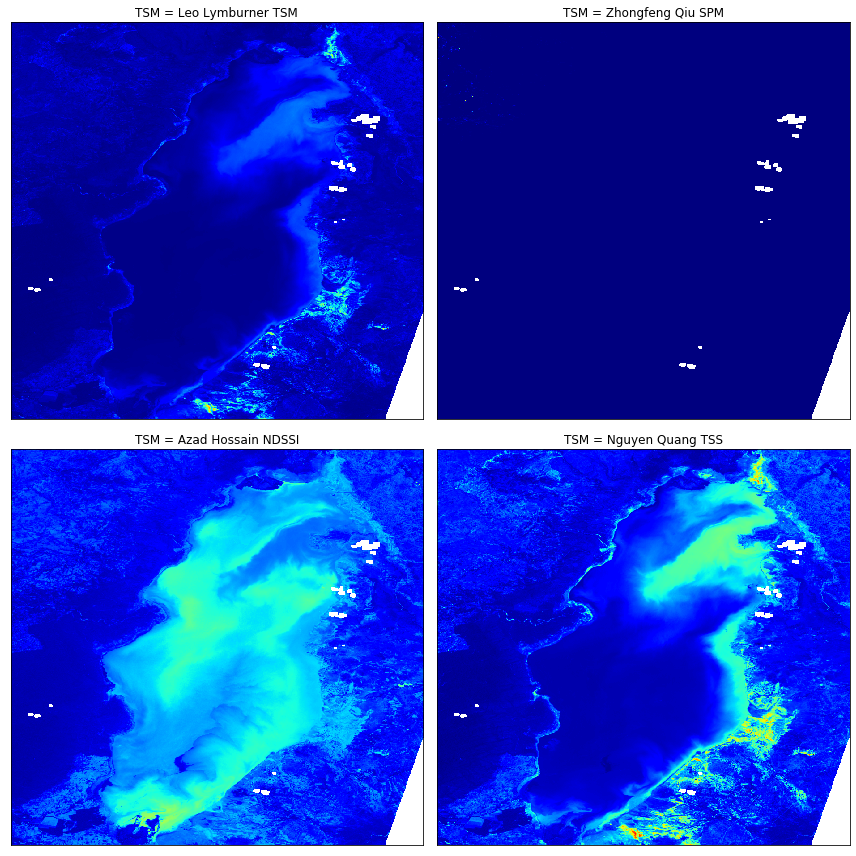

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

(lym8).plot.imshow(ax=ax[0,0], cmap = "jet", add_colorbar=False)
(spm_qiu).plot.imshow(ax=ax[0,1], cmap = "jet", add_colorbar=False)
(ndssi).plot.imshow(ax=ax[1,0], cmap = "jet", vmin=-1.0, vmax=1.0, add_colorbar=False)
(quang8).plot.imshow(ax=ax[1,1], cmap = "jet", add_colorbar=False)

print('Total Suspended Matter (Blue=Low, Green=Medium-Low, Orange=Medium-High, Red=High)')

# Titles
ax[0,0].set_title('TSM = Leo Lymburner TSM'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('TSM = Zhongfeng Qiu SPM'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('TSM = Azad Hossain NDSSI'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('TSM = Nguyen Quang TSS'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()